# NeurIPS Open Polymer Prediction 2025

## 1. Import Libraries and Setup

In [32]:
# Core libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Chemistry libraries for SMILES processing
from rdkit import Chem
from rdkit.Chem import Descriptors, AllChem, rdMolDescriptors
from rdkit.Chem import Fragments, Lipinski, Crippen, MolFromSmiles

# Machine Learning
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.metrics import mean_absolute_error
import xgboost as xgb
import lightgbm as lgb

# Deep Learning
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)

# Plotting configuration
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

## 2. Load Data

In [33]:
# Data directory
DATA_DIR = Path(r"C:\Users\gopeami\OneDrive - Vesuvius\Desktop\PhD13- 2025-2026\ML Practice\Kaggle Compettition\NeuIPS Polymer\neurips-open-polymer-prediction-2025")

# Load training data
train_df = pd.read_csv(DATA_DIR / 'train.csv')
test_df = pd.read_csv(DATA_DIR / 'test.csv')
sample_submission = pd.read_csv(DATA_DIR / 'sample_submission.csv')

print(f"Training data shape: {train_df.shape}")
print(f"Test data shape: {test_df.shape}")
print(f"\nTraining data columns: {train_df.columns.tolist()}")
print(f"\nFirst few rows of training data:")
display(train_df.head())

print(f"\n\nSample submission format:")
display(sample_submission.head())

Training data shape: (7973, 7)
Test data shape: (3, 2)

Training data columns: ['id', 'SMILES', 'Tg', 'FFV', 'Tc', 'Density', 'Rg']

First few rows of training data:


,id,SMILES,Tg,FFV,Tc,Density,Rg
0,87817,*CC(*)c1ccccc1C(=O)OCCCCCC,NaN,0.374645,0.205667,NaN,NaN
1,106919,*Nc1ccc([C@H](CCC)c2ccc(C3(c4ccc([C@@H](CCC)c5...,NaN,0.370410,NaN,NaN,NaN
2,388772,*Oc1ccc(S(=O)(=O)c2ccc(Oc3ccc(C4(c5ccc(Oc6ccc(...,NaN,0.378860,NaN,NaN,NaN
3,519416,*Nc1ccc(-c2c(-c3ccc(C)cc3)c(-c3ccc(C)cc3)c(N*)...,NaN,0.387324,NaN,NaN,NaN
4,539187,*Oc1ccc(OC(=O)c2cc(OCCCCCCCCCOCC3CCCN3c3ccc([N...,NaN,0.355470,NaN,NaN,NaN




Sample submission format:


,id,Tg,FFV,Tc,Density,Rg
0,1109053969,0,0,0,0,0
1,1422188626,0,0,0,0,0
2,2032016830,0,0,0,0,0


In [34]:
# Define target properties (use exact column names from the data)
TARGET_PROPERTIES = ['Density', 'Tc', 'Tg', 'Rg', 'FFV']
print(f"Target properties: {TARGET_PROPERTIES}")

Target properties: ['Density', 'Tc', 'Tg', 'Rg', 'FFV']


### 2.1 Load Additional Training Data for Robustness

In [35]:
# Look for additional data files in the same parent directory
import glob
from pathlib import Path

BASE_DIR = Path(r"C:\Users\gopeami\OneDrive - Vesuvius\Desktop\PhD13- 2025-2026\ML Practice\Kaggle Compettition\NeuIPS Polymer")

print("Searching for additional training data...")
print(f"Base directory: {BASE_DIR}")
print("="*80)

# Search for all CSV files that might contain additional training data
additional_data_files = []
search_patterns = [
    'train*.csv',
    '*train*.csv', 
    '*additional*.csv',
    '*extra*.csv',
    '*supplemental*.csv',
    '*augment*.csv'
]

for pattern in search_patterns:
    found_files = list(BASE_DIR.rglob(pattern))
    for f in found_files:
        if f not in additional_data_files and f != (DATA_DIR / 'train.csv'):
            additional_data_files.append(f)

print(f"\nFound {len(additional_data_files)} potential additional data files:")
for i, file in enumerate(additional_data_files, 1):
    print(f"{i}. {file.relative_to(BASE_DIR) if file.is_relative_to(BASE_DIR) else file}")

# Also check for subdirectories that might contain data
subdirs = [d for d in BASE_DIR.iterdir() if d.is_dir() and d != DATA_DIR]
print(f"\n\nOther subdirectories in base location:")
for subdir in subdirs[:10]:  # Show first 10
    print(f"  - {subdir.name}")

Searching for additional training data...
Base directory: C:\Users\gopeami\OneDrive - Vesuvius\Desktop\PhD13- 2025-2026\ML Practice\Kaggle Compettition\NeuIPS Polymer

Found 0 potential additional data files:


Other subdirectories in base location:


In [ ]:
# Function to load and merge additional training data
def load_additional_data(file_paths, original_df):
    additional_dfs = []
    
    print("\nLoading additional training data...")
    print("="*80)
    
    for file_path in file_paths:
        try:
            df = pd.read_csv(file_path)
            
            # Check if it has similar structure to training data
            required_col = 'SMILES'
            if required_col in df.columns:
                print(f"\n✓ Loaded: {file_path.name}")
                print(f"  Shape: {df.shape}")
                print(f"  Columns: {df.columns.tolist()}")
                
                # Check which target properties are present
                properties_present = [prop for prop in TARGET_PROPERTIES if prop in df.columns]
                print(f"  Properties available: {properties_present}")
                
                additional_dfs.append(df)
            else:
                print(f"\n✗ Skipped: {file_path.name} (missing SMILES column)")
                
        except Exception as e:
            print(f"\n✗ Error loading {file_path.name}: {str(e)}")
    
    if not additional_dfs:
        print("\nNo additional data loaded. Using original training data only.")
        return original_df
    
    # Combine all dataframes
    print(f"\n\nMerging {len(additional_dfs)} additional datasets with original data...")
    all_dfs = [original_df] + additional_dfs
    
    # Concatenate and remove duplicates based on SMILES
    merged_df = pd.concat(all_dfs, ignore_index=True)
    
    print(f"\nBefore deduplication: {len(merged_df)} samples")
    
    # Remove duplicates, keeping first occurrence
    merged_df = merged_df.drop_duplicates(subset=['SMILES'], keep='first')
    
    print(f"After deduplication: {len(merged_df)} samples")
    print(f"Added {len(merged_df) - len(original_df)} new unique samples")
    
    return merged_df

# Store original training data
train_df_original = train_df.copy()

# Example: Specify additional data paths manually or use discovered files
# Uncomment and modify paths as needed:
additional_data_paths = []

# Option 1: Manually specify additional data files
# additional_data_paths = [
#     BASE_DIR / 'additional_folder' / 'train_extra.csv',
#     BASE_DIR / 'supplemental_data' / 'polymer_data.csv',
# ]

# Option 2: Use automatically discovered files (if any)
if additional_data_files:
    print("\nDiscovered additional data files. Review and select which to include:")
    for i, file in enumerate(additional_data_files, 1):
        print(f"{i}. {file}")
    
    # Uncomment to use all discovered files:
    # additional_data_paths = additional_data_files
    
    # Or manually select by index:
    # additional_data_paths = [additional_data_files[0], additional_data_files[1]]

# Load additional data if paths are specified
if additional_data_paths:
    train_df = load_additional_data(additional_data_paths, train_df_original)
else:
    print("\n" + "="*80)
    print("No additional data paths specified.")
    print("To add additional data, set 'additional_data_paths' to a list of file paths.")
    print("="*80)
    print("\nExample:")
    print("additional_data_paths = [")
    print("    BASE_DIR / 'folder_name' / 'additional_train.csv',")
    print("]")
    print("\nThen re-run this cell.")


No additional data paths specified.
To add additional data, set 'additional_data_paths' to a list of file paths.

Example:
additional_data_paths = [
    BASE_DIR / 'folder_name' / 'additional_train.csv',
]

Then re-run this cell.



Training Data Comparison:
Original training data: 7973 samples
Current training data:  7973 samples
Increase: 0 samples (0.0%)


Property coverage comparison:
--------------------------------------------------------------------------------
Property        Original Count       Augmented Count      Increase       
--------------------------------------------------------------------------------
Density         613                  613                  +0 (0.0%)
Tc              737                  737                  +0 (0.0%)
Tg              511                  511                  +0 (0.0%)
Rg              614                  614                  +0 (0.0%)
FFV             7030                 7030                 +0 (0.0%)


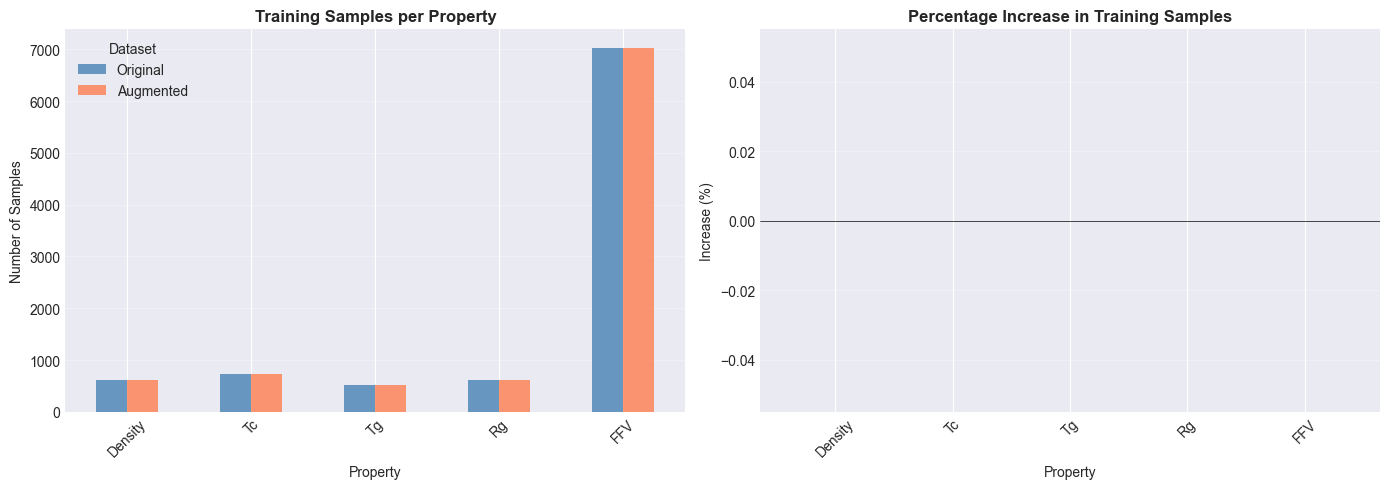

In [37]:
# Compare original vs augmented training data
print("\nTraining Data Comparison:")
print("="*80)
print(f"Original training data: {train_df_original.shape[0]} samples")
print(f"Current training data:  {train_df.shape[0]} samples")
print(f"Increase: {train_df.shape[0] - train_df_original.shape[0]} samples ({((train_df.shape[0]/train_df_original.shape[0] - 1)*100):.1f}%)")

print("\n\nProperty coverage comparison:")
print("-"*80)
print(f"{'Property':<15} {'Original Count':<20} {'Augmented Count':<20} {'Increase':<15}")
print("-"*80)

for prop in TARGET_PROPERTIES:
    original_count = train_df_original[prop].notna().sum()
    current_count = train_df[prop].notna().sum()
    increase = current_count - original_count
    
    print(f"{prop:<15} {original_count:<20} {current_count:<20} +{increase} ({(increase/original_count*100):.1f}%)" if original_count > 0 else f"{prop:<15} {original_count:<20} {current_count:<20} +{increase}")

# Visualize the data augmentation impact
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Bar chart comparing counts
counts_comparison = pd.DataFrame({
    'Original': [train_df_original[prop].notna().sum() for prop in TARGET_PROPERTIES],
    'Augmented': [train_df[prop].notna().sum() for prop in TARGET_PROPERTIES]
}, index=TARGET_PROPERTIES)

counts_comparison.plot(kind='bar', ax=axes[0], color=['steelblue', 'coral'], alpha=0.8)
axes[0].set_title('Training Samples per Property', fontweight='bold', fontsize=12)
axes[0].set_xlabel('Property')
axes[0].set_ylabel('Number of Samples')
axes[0].legend(title='Dataset')
axes[0].grid(True, alpha=0.3, axis='y')
axes[0].tick_params(axis='x', rotation=45)

# Percentage increase
increase_pct = []
for prop in TARGET_PROPERTIES:
    original = train_df_original[prop].notna().sum()
    current = train_df[prop].notna().sum()
    pct = ((current / original - 1) * 100) if original > 0 else 0
    increase_pct.append(pct)

axes[1].bar(TARGET_PROPERTIES, increase_pct, color='forestgreen', alpha=0.7)
axes[1].set_title('Percentage Increase in Training Samples', fontweight='bold', fontsize=12)
axes[1].set_xlabel('Property')
axes[1].set_ylabel('Increase (%)')
axes[1].grid(True, alpha=0.3, axis='y')
axes[1].tick_params(axis='x', rotation=45)
axes[1].axhline(y=0, color='black', linestyle='-', linewidth=0.5)

plt.tight_layout()
plt.show()

### 2.2 Alternative: SMILES Augmentation for Robustness

If no additional external data is available, we can use SMILES augmentation to increase training robustness:

In [ ]:
# SMILES Augmentation: Generate different valid SMILES representations
# This helps models learn invariant features

def augment_smiles(smiles, n_augmentations=3):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return [smiles]
    
    augmented = [smiles]  # Include original
    
    for _ in range(n_augmentations):
        try:
            # Randomize atom order and generate new SMILES
            new_smiles = Chem.MolToSmiles(mol, doRandom=True)
            if new_smiles not in augmented:
                augmented.append(new_smiles)
        except:
            continue
    
    return augmented

def create_augmented_dataset(df, n_augmentations=2, use_augmentation=False):
    if not use_augmentation:
        print("SMILES augmentation is disabled. Set use_augmentation=True to enable.")
        return df
    
    print(f"Creating augmented dataset with {n_augmentations} variations per molecule...")
    
    augmented_rows = []
    
    for idx, row in df.iterrows():
        smiles = row['SMILES']
        augmented_smiles = augment_smiles(smiles, n_augmentations)
        
        # Create a row for each augmented SMILES
        for aug_smiles in augmented_smiles:
            new_row = row.copy()
            new_row['SMILES'] = aug_smiles
            new_row['original_idx'] = idx
            new_row['is_augmented'] = (aug_smiles != smiles)
            augmented_rows.append(new_row)
        
        if (idx + 1) % 1000 == 0:
            print(f"Processed {idx + 1} molecules...")
    
    augmented_df = pd.DataFrame(augmented_rows)
    
    print(f"\nOriginal dataset: {len(df)} samples")
    print(f"Augmented dataset: {len(augmented_df)} samples")
    print(f"Augmentation factor: {len(augmented_df) / len(df):.2f}x")
    
    return augmented_df

# Option to enable SMILES augmentation (disabled by default for speed)
USE_SMILES_AUGMENTATION = False  # Set to True to enable
N_AUGMENTATIONS = 2  # Number of augmented versions per molecule

if USE_SMILES_AUGMENTATION:
    print("Applying SMILES augmentation...")
    train_df_augmented = create_augmented_dataset(
        train_df, 
        n_augmentations=N_AUGMENTATIONS, 
        use_augmentation=True
    )
    
    # Update training dataframe
    train_df = train_df_augmented
    
    print("\n✓ SMILES augmentation applied")
    print(f"  New training size: {len(train_df)} samples")
else:
    print("SMILES augmentation is currently disabled.")
    print("To enable, set USE_SMILES_AUGMENTATION = True and re-run this cell.")
    print("\nBenefits of SMILES augmentation:")
    print("  - Improves model robustness to different SMILES representations")
    print("  - Acts as data augmentation without changing chemical structure")
    print("  - Helps models learn invariant molecular features")
    print(f"\nCurrent training size: {len(train_df)} samples")

SMILES augmentation is currently disabled.
To enable, set USE_SMILES_AUGMENTATION = True and re-run this cell.

Benefits of SMILES augmentation:
  - Improves model robustness to different SMILES representations
  - Acts as data augmentation without changing chemical structure
  - Helps models learn invariant molecular features

Current training size: 7973 samples


### 2.3 Quick Guide: Adding External Polymer Databases

Common sources for additional polymer data:

In [39]:
# Load additional training data from supplement folder
SUPPLEMENT_DIR = Path(r"C:\Users\gopeami\OneDrive - Vesuvius\Desktop\PhD13- 2025-2026\ML Practice\Kaggle Compettition\NeuIPS Polymer\neurips-open-polymer-prediction-2025\train_supplement")

print("Loading supplemental training data...")
print(f"Supplement directory: {SUPPLEMENT_DIR}")
print("="*80)

# Check if directory exists
if SUPPLEMENT_DIR.exists() and SUPPLEMENT_DIR.is_dir():
    # Find all CSV files in the supplement directory
    supplement_files = list(SUPPLEMENT_DIR.glob('*.csv'))
    
    print(f"\nFound {len(supplement_files)} CSV file(s) in supplement directory:")
    for i, file in enumerate(supplement_files, 1):
        print(f"  {i}. {file.name}")
    
    if supplement_files:
        # Load the supplemental data
        train_df = load_additional_data(supplement_files, train_df_original)
        
        print("\n" + "="*80)
        print("✓ Supplemental training data loaded successfully!")
        print("="*80)
    else:
        print("\n⚠ No CSV files found in the supplement directory.")
        print("Using original training data only.")
else:
    print(f"\n⚠ Supplement directory not found: {SUPPLEMENT_DIR}")
    print("Using original training data only.")
    print("\nPlease verify the path is correct.")

Loading supplemental training data...
Supplement directory: C:\Users\gopeami\OneDrive - Vesuvius\Desktop\PhD13- 2025-2026\ML Practice\Kaggle Compettition\NeuIPS Polymer\neurips-open-polymer-prediction-2025\train_supplement

Found 4 CSV file(s) in supplement directory:
  1. dataset1.csv
  2. dataset2.csv
  3. dataset3.csv
  4. dataset4.csv

Loading additional training data...

✓ Loaded: dataset1.csv
  Shape: (874, 2)
  Columns: ['SMILES', 'TC_mean']
  Properties available: []

✓ Loaded: dataset2.csv
  Shape: (7208, 1)
  Columns: ['SMILES']
  Properties available: []

✓ Loaded: dataset3.csv
  Shape: (46, 2)
  Columns: ['SMILES', 'Tg']
  Properties available: ['Tg']

✓ Loaded: dataset4.csv
  Shape: (862, 2)
  Columns: ['SMILES', 'FFV']
  Properties available: ['FFV']


Merging 4 additional datasets with original data...

Before deduplication: 16963 samples
After deduplication: 10345 samples
Added 2372 new unique samples

✓ Supplemental training data loaded successfully!


## 3. Exploratory Data Analysis

In [40]:
# Check for missing values
print("Missing values in training data:")
print(train_df.isnull().sum())

print("\n\nBasic statistics for target properties:")
display(train_df[TARGET_PROPERTIES].describe())

# Check how many samples we have for each property
print("\n\nSamples available for each property:")
for prop in TARGET_PROPERTIES:
    count = train_df[prop].notna().sum()
    print(f"{prop}: {count} ({count/len(train_df)*100:.2f}%)")

Missing values in training data:
id          2372
SMILES         0
Tg          9788
FFV         3043
Tc          9608
Density     9732
Rg          9731
TC_mean    10215
dtype: int64


Basic statistics for target properties:


,Density,Tc,Tg,Rg,FFV
count,613.000000,737.000000,557.000000,614.000000,7302.000000
mean,0.985484,0.256334,99.693183,16.419787,0.366858
std,0.146189,0.089538,111.075991,4.608640,0.029289
min,0.748691,0.046500,-148.029738,9.728355,0.226992
25%,0.890243,0.186000,17.013426,12.540328,0.349488
50%,0.948193,0.236000,77.846783,15.052194,0.363895
75%,1.062096,0.330500,164.863901,20.411067,0.380167
max,1.840999,0.524000,472.250000,34.672906,0.777097




Samples available for each property:
Density: 613 (5.93%)
Tc: 737 (7.12%)
Tg: 557 (5.38%)
Rg: 614 (5.94%)
FFV: 7302 (70.58%)


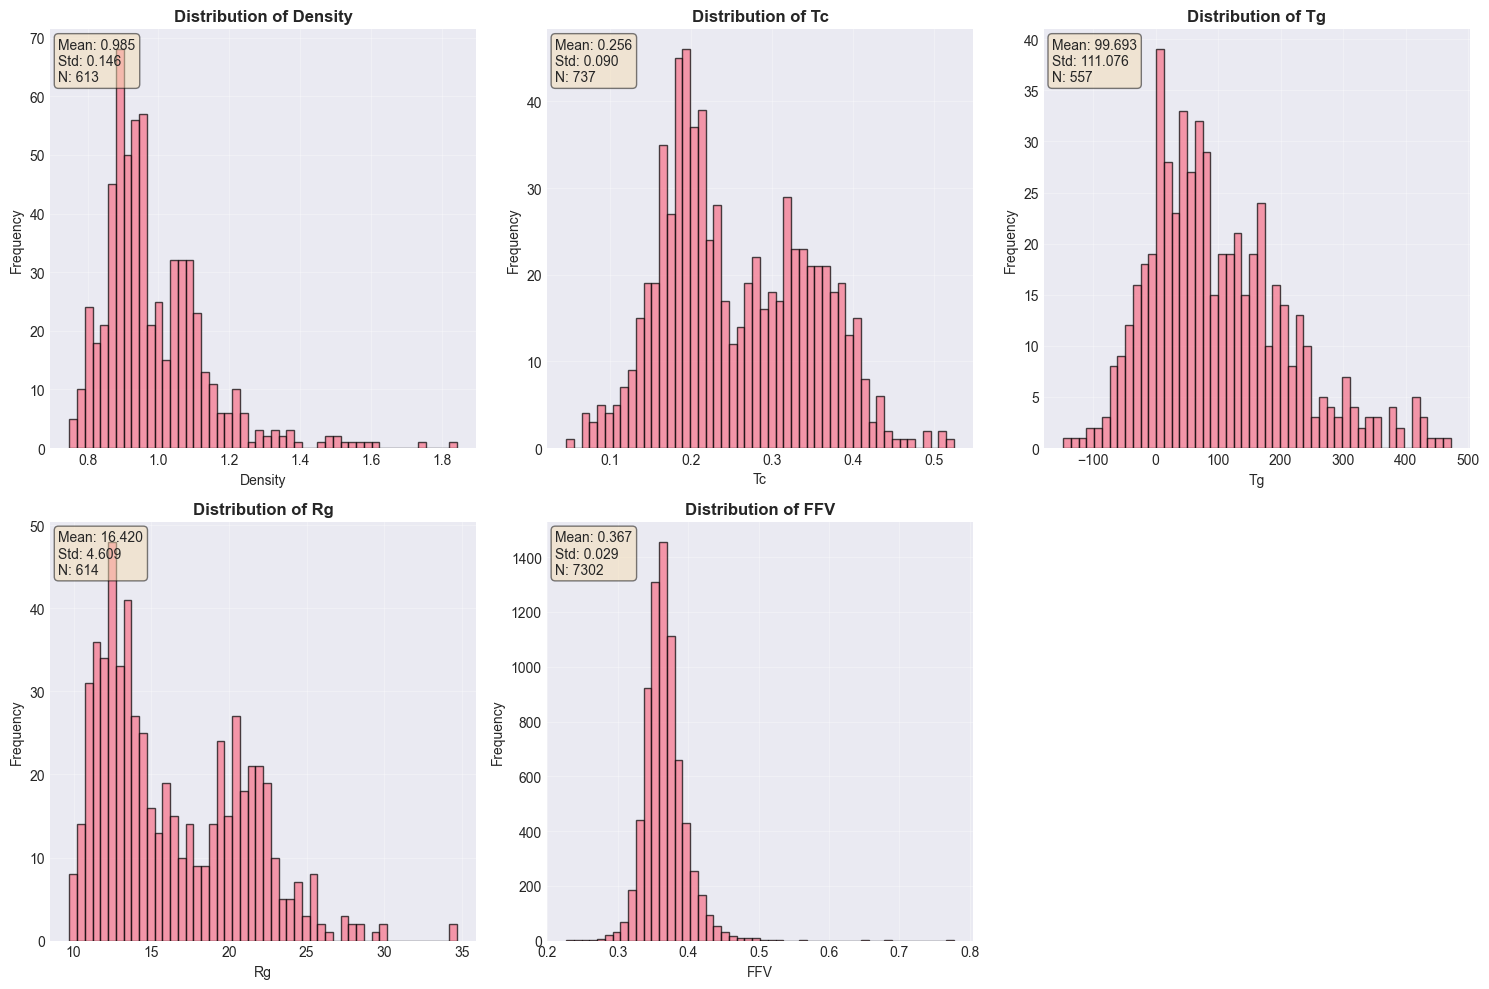

In [41]:
# Visualize target distributions
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for idx, prop in enumerate(TARGET_PROPERTIES):
    data = train_df[prop].dropna()
    axes[idx].hist(data, bins=50, edgecolor='black', alpha=0.7)
    axes[idx].set_title(f'Distribution of {prop}', fontsize=12, fontweight='bold')
    axes[idx].set_xlabel(prop)
    axes[idx].set_ylabel('Frequency')
    axes[idx].grid(True, alpha=0.3)
    
    # Add statistics
    axes[idx].text(0.02, 0.98, f'Mean: {data.mean():.3f}\nStd: {data.std():.3f}\nN: {len(data)}',
                   transform=axes[idx].transAxes, verticalalignment='top',
                   bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

axes[-1].axis('off')  # Turn off last subplot
plt.tight_layout()
plt.show()

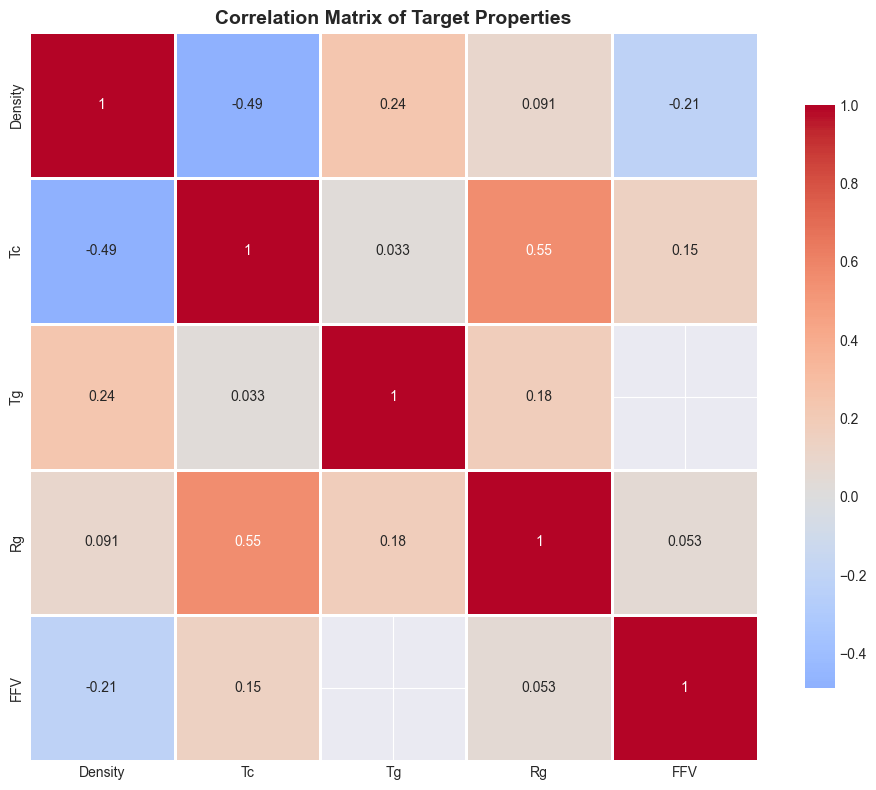

In [42]:
# Correlation matrix of target properties
correlation_matrix = train_df[TARGET_PROPERTIES].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, 
            square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Correlation Matrix of Target Properties', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

## 4. Feature Engineering from SMILES

We'll extract molecular descriptors and fingerprints from SMILES strings:

In [ ]:
def extract_molecular_features(smiles):
    mol = Chem.MolFromSmiles(smiles)
    
    if mol is None:
        return None
    
    features = {}
    
    try:
        # Basic molecular descriptors
        features['mol_weight'] = Descriptors.MolWt(mol)
        features['num_atoms'] = mol.GetNumAtoms()
        features['num_heavy_atoms'] = Descriptors.HeavyAtomCount(mol)
        features['num_rotatable_bonds'] = Descriptors.NumRotatableBonds(mol)
        features['num_h_acceptors'] = Descriptors.NumHAcceptors(mol)
        features['num_h_donors'] = Descriptors.NumHDonors(mol)
        features['num_heteroatoms'] = Descriptors.NumHeteroatoms(mol)
        features['num_rings'] = Descriptors.RingCount(mol)
        features['num_aromatic_rings'] = Descriptors.NumAromaticRings(mol)
        features['num_saturated_rings'] = Descriptors.NumSaturatedRings(mol)
        features['num_aliphatic_rings'] = Descriptors.NumAliphaticRings(mol)
        
        # Topological descriptors
        features['tpsa'] = Descriptors.TPSA(mol)  # Topological polar surface area
        features['labute_asa'] = Descriptors.LabuteASA(mol)  # Labute ASA
        features['balaban_j'] = Descriptors.BalabanJ(mol)
        features['bertz_ct'] = Descriptors.BertzCT(mol)
        features['chi0'] = Descriptors.Chi0(mol)
        features['chi1'] = Descriptors.Chi1(mol)
        features['kappa1'] = Descriptors.Kappa1(mol)
        features['kappa2'] = Descriptors.Kappa2(mol)
        features['kappa3'] = Descriptors.Kappa3(mol)
        
        # Physical/Chemical descriptors
        features['logp'] = Descriptors.MolLogP(mol)
        features['mr'] = Descriptors.MolMR(mol)  # Molar refractivity
        
        # Calculate Csp3 fraction manually
        num_csp3 = sum(1 for atom in mol.GetAtoms() if atom.GetHybridization() == Chem.HybridizationType.SP3 and atom.GetSymbol() == 'C')
        num_carbons = sum(1 for atom in mol.GetAtoms() if atom.GetSymbol() == 'C')
        features['fraction_csp3'] = num_csp3 / num_carbons if num_carbons > 0 else 0
        
        # Pharmacophore features
        features['num_lipinski_hba'] = Lipinski.NumHAcceptors(mol)
        features['num_lipinski_hbd'] = Lipinski.NumHDonors(mol)
        
        # Crippen descriptors
        features['crippen_logp'] = Crippen.MolLogP(mol)
        features['crippen_mr'] = Crippen.MolMR(mol)
        
        # Additional descriptors
        features['num_valence_electrons'] = Descriptors.NumValenceElectrons(mol)
        features['max_partial_charge'] = Descriptors.MaxPartialCharge(mol)
        features['min_partial_charge'] = Descriptors.MinPartialCharge(mol)
        features['max_abs_partial_charge'] = Descriptors.MaxAbsPartialCharge(mol)
        features['min_abs_partial_charge'] = Descriptors.MinAbsPartialCharge(mol)
        
        # Fragment counts (important for polymer properties)
        features['num_aliphatic_carbocycles'] = Fragments.fr_Al_COO(mol)
        features['num_aliphatic_hydroxyl'] = Fragments.fr_Al_OH(mol)
        features['num_aromatic_hydroxyl'] = Fragments.fr_Ar_OH(mol)
        features['num_benzene'] = Fragments.fr_benzene(mol)
        features['num_ester'] = Fragments.fr_ester(mol)
        features['num_ether'] = Fragments.fr_ether(mol)
        features['num_methoxy'] = Fragments.fr_methoxy(mol)
        
    except Exception as e:
        print(f"Error extracting features for SMILES {smiles}: {e}")
        return None
    
    return features

def get_morgan_fingerprint(smiles, radius=2, n_bits=2048):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return np.zeros(n_bits)
    
    # Use the new MorganGenerator API to avoid deprecation warnings
    from rdkit.Chem import rdFingerprintGenerator
    mfpgen = rdFingerprintGenerator.GetMorganGenerator(radius=radius, fpSize=n_bits)
    fp = mfpgen.GetFingerprint(mol)
    return np.array(fp)

print("Feature extraction functions defined successfully!")

Feature extraction functions defined successfully!


In [44]:
# Extract features for training and test data
print("Extracting molecular features from SMILES...")

# Extract descriptors
train_features = []
for smiles in train_df['SMILES']:
    features = extract_molecular_features(smiles)
    train_features.append(features)

test_features = []
for smiles in test_df['SMILES']:
    features = extract_molecular_features(smiles)
    test_features.append(features)

# Convert to DataFrame
train_desc = pd.DataFrame(train_features)
test_desc = pd.DataFrame(test_features)

print(f"Extracted {train_desc.shape[1]} molecular descriptors")
print(f"Training features shape: {train_desc.shape}")
print(f"Test features shape: {test_desc.shape}")

# Handle inf and NaN values in descriptors
print("\nCleaning features...")
train_desc = train_desc.replace([np.inf, -np.inf], np.nan)
test_desc = test_desc.replace([np.inf, -np.inf], np.nan)

# Fill NaN with median values
for col in train_desc.columns:
    median_val = train_desc[col].median()
    train_desc[col].fillna(median_val, inplace=True)
    test_desc[col].fillna(median_val, inplace=True)

print("✓ Features cleaned")

# Extract Morgan fingerprints
print("\nGenerating Morgan fingerprints...")
train_fps = np.array([get_morgan_fingerprint(smiles) for smiles in train_df['SMILES']])
test_fps = np.array([get_morgan_fingerprint(smiles) for smiles in test_df['SMILES']])

print(f"Fingerprint shape: {train_fps.shape}")

# Combine descriptors and fingerprints
X_train_combined = np.hstack([train_desc.values, train_fps])
X_test_combined = np.hstack([test_desc.values, test_fps])

print(f"\nCombined feature shape: {X_train_combined.shape}")
print(f"Total features: {X_train_combined.shape[1]}")

Extracting molecular features from SMILES...
Extracted 39 molecular descriptors
Training features shape: (10345, 39)
Test features shape: (3, 39)

Cleaning features...
✓ Features cleaned

Generating Morgan fingerprints...
Fingerprint shape: (10345, 2048)

Combined feature shape: (10345, 2087)
Total features: 2087


## 5. Competition Evaluation Metric

Implement the weighted Mean Absolute Error (wMAE) as specified in the competition:

In [ ]:
def calculate_wmae(y_true, y_pred, property_ranges=None):
    
    if isinstance(y_true, pd.DataFrame):
        y_true = {col: y_true[col].values for col in y_true.columns}
    if isinstance(y_pred, pd.DataFrame):
        y_pred = {col: y_pred[col].values for col in y_pred.columns}
    
    properties = list(y_true.keys())
    total_tasks = len(properties)
    
    # Calculate property ranges if not provided
    if property_ranges is None:
        property_ranges = {}
        for prop in properties:
            valid_mask = ~np.isnan(y_true[prop])
            if valid_mask.sum() > 0:
                property_ranges[prop] = np.ptp(y_true[prop][valid_mask])  # peak-to-peak (max - min)
            else:
                property_ranges[prop] = 1.0  # fallback
    
    # Calculate weights for each property
    weights = {}
    for prop in properties:
        valid_mask = ~np.isnan(y_true[prop])
        N_i = valid_mask.sum()
        range_i = property_ranges[prop]
        
        if N_i > 0 and range_i > 0:
            weights[prop] = 1.0 / (range_i * np.sqrt(N_i))
        else:
            weights[prop] = 0.0
    
    # Normalize weights
    sum_weights = sum(weights.values())
    if sum_weights > 0:
        for prop in properties:
            weights[prop] = (weights[prop] / sum_weights) * total_tasks
    
    # Calculate weighted MAE
    wmae = 0.0
    for prop in properties:
        valid_mask = ~np.isnan(y_true[prop])
        if valid_mask.sum() > 0:
            mae = np.mean(np.abs(y_true[prop][valid_mask] - y_pred[prop][valid_mask]))
            wmae += weights[prop] * mae
    
    return wmae

print("Competition metric (wMAE) implemented successfully!")

Competition metric (wMAE) implemented successfully!


## 6. Baseline Models

We'll build separate models for each property using gradient boosting methods:

In [46]:
# Prepare data with feature scaling
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train_combined)
X_test_scaled = scaler.transform(X_test_combined)

# Initialize storage for models and predictions
models = {}
cv_scores = {}
test_predictions = {}

print("Training separate models for each property...\n")

# Train a model for each property
for prop in TARGET_PROPERTIES:
    print(f"{'='*60}")
    print(f"Training model for: {prop}")
    print(f"{'='*60}")
    
    # Get valid training samples for this property
    valid_mask = train_df[prop].notna()
    X_prop = X_train_scaled[valid_mask]
    y_prop = train_df.loc[valid_mask, prop].values
    
    print(f"Training samples: {len(y_prop)}")
    print(f"Target range: [{y_prop.min():.4f}, {y_prop.max():.4f}]")
    print(f"Target mean: {y_prop.mean():.4f}, std: {y_prop.std():.4f}")
    
    # Create ensemble of models
    # LightGBM model (usually performs well for tabular data)
    lgb_model = lgb.LGBMRegressor(
        n_estimators=1000,
        learning_rate=0.05,
        max_depth=8,
        num_leaves=63,
        min_child_samples=20,
        subsample=0.8,
        colsample_bytree=0.8,
        reg_alpha=0.1,
        reg_lambda=0.1,
        random_state=42,
        n_jobs=-1,
        verbose=-1
    )
    
    # XGBoost model
    xgb_model = xgb.XGBRegressor(
        n_estimators=1000,
        learning_rate=0.05,
        max_depth=8,
        min_child_weight=3,
        subsample=0.8,
        colsample_bytree=0.8,
        reg_alpha=0.1,
        reg_lambda=0.1,
        random_state=42,
        n_jobs=-1
    )
    
    # Train with cross-validation
    kfold = KFold(n_splits=5, shuffle=True, random_state=42)
    
    lgb_scores = []
    xgb_scores = []
    
    for fold, (train_idx, val_idx) in enumerate(kfold.split(X_prop)):
        X_tr, X_val = X_prop[train_idx], X_prop[val_idx]
        y_tr, y_val = y_prop[train_idx], y_prop[val_idx]
        
        # Train LightGBM
        lgb_model.fit(X_tr, y_tr, 
                     eval_set=[(X_val, y_val)],
                     callbacks=[lgb.early_stopping(50, verbose=False)])
        lgb_pred = lgb_model.predict(X_val)
        lgb_mae = mean_absolute_error(y_val, lgb_pred)
        lgb_scores.append(lgb_mae)
        
        # Train XGBoost
        xgb_model.fit(X_tr, y_tr,
                     eval_set=[(X_val, y_val)],
                     verbose=False)
        xgb_pred = xgb_model.predict(X_val)
        xgb_mae = mean_absolute_error(y_val, xgb_pred)
        xgb_scores.append(xgb_mae)
    
    print(f"\nCross-validation results:")
    print(f"LightGBM MAE: {np.mean(lgb_scores):.4f} (+/- {np.std(lgb_scores):.4f})")
    print(f"XGBoost MAE:  {np.mean(xgb_scores):.4f} (+/- {np.std(xgb_scores):.4f})")
    
    # Train final models on all data
    lgb_model.fit(X_prop, y_prop)
    xgb_model.fit(X_prop, y_prop)
    
    # Make predictions (ensemble average)
    lgb_test_pred = lgb_model.predict(X_test_scaled)
    xgb_test_pred = xgb_model.predict(X_test_scaled)
    ensemble_pred = (lgb_test_pred + xgb_test_pred) / 2
    
    # Store results
    models[prop] = {'lgb': lgb_model, 'xgb': xgb_model}
    cv_scores[prop] = {'lgb': np.mean(lgb_scores), 'xgb': np.mean(xgb_scores)}
    test_predictions[prop] = ensemble_pred
    
    print(f"\n")

print("\n" + "="*60)
print("All models trained successfully!")
print("="*60)

Training separate models for each property...

Training model for: Density
Training samples: 613
Target range: [0.7487, 1.8410]
Target mean: 0.9855, std: 0.1461

Cross-validation results:
LightGBM MAE: 0.0381 (+/- 0.0076)
XGBoost MAE:  0.0342 (+/- 0.0077)


Training model for: Tc
Training samples: 737
Target range: [0.0465, 0.5240]
Target mean: 0.2563, std: 0.0895

Cross-validation results:
LightGBM MAE: 0.0279 (+/- 0.0020)
XGBoost MAE:  0.0277 (+/- 0.0022)


Training model for: Tg
Training samples: 557
Target range: [-148.0297, 472.2500]
Target mean: 99.6932, std: 110.9762

Cross-validation results:
LightGBM MAE: 51.3700 (+/- 2.9828)
XGBoost MAE:  54.1744 (+/- 3.1962)


Training model for: Rg
Training samples: 614
Target range: [9.7284, 34.6729]
Target mean: 16.4198, std: 4.6049

Cross-validation results:
LightGBM MAE: 1.6734 (+/- 0.1440)
XGBoost MAE:  1.6143 (+/- 0.1189)


Training model for: FFV
Training samples: 7302
Target range: [0.2270, 0.7771]
Target mean: 0.3669, std: 0.0293



Cross-Validation Scores Summary:


,LightGBM MAE,XGBoost MAE,Average
Density,0.038057,0.034156,0.036106
Tc,0.027927,0.027747,0.027837
Tg,51.369969,54.174387,52.772178
Rg,1.673441,1.614308,1.643875
FFV,0.006889,0.006144,0.006517


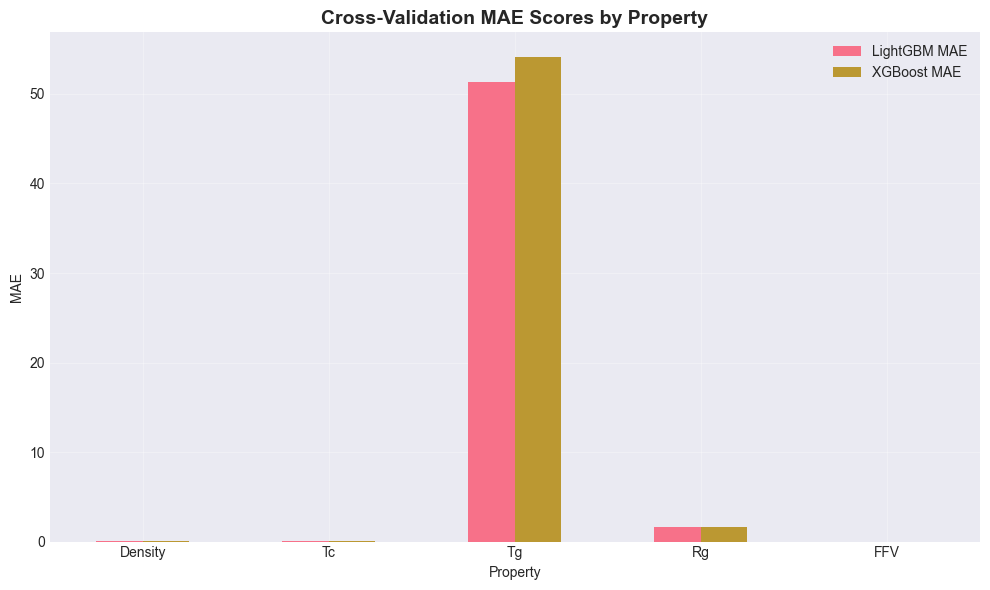

In [47]:
# Display CV scores summary
print("Cross-Validation Scores Summary:")
print("="*60)
cv_df = pd.DataFrame(cv_scores).T
cv_df.columns = ['LightGBM MAE', 'XGBoost MAE']
cv_df['Average'] = cv_df.mean(axis=1)
display(cv_df)

# Visualize CV scores
fig, ax = plt.subplots(figsize=(10, 6))
cv_df[['LightGBM MAE', 'XGBoost MAE']].plot(kind='bar', ax=ax, rot=0)
plt.title('Cross-Validation MAE Scores by Property', fontsize=14, fontweight='bold')
plt.xlabel('Property')
plt.ylabel('MAE')
plt.legend(loc='best')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 7. Deep Learning Model

Build a neural network for multi-task learning:

In [48]:
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

class MultiTaskNN(nn.Module):
    def __init__(self, input_dim, num_tasks=5, hidden_dims=[512, 256, 128]):
        super(MultiTaskNN, self).__init__()
        
        # Shared layers
        layers = []
        prev_dim = input_dim
        for hidden_dim in hidden_dims:
            layers.extend([
                nn.Linear(prev_dim, hidden_dim),
                nn.BatchNorm1d(hidden_dim),
                nn.ReLU(),
                nn.Dropout(0.3)
            ])
            prev_dim = hidden_dim
        
        self.shared_layers = nn.Sequential(*layers)
        
        # Task-specific heads
        self.task_heads = nn.ModuleList([
            nn.Linear(hidden_dims[-1], 1) for _ in range(num_tasks)
        ])
    
    def forward(self, x):
        shared_output = self.shared_layers(x)
        outputs = torch.cat([head(shared_output) for head in self.task_heads], dim=1)
        return outputs

def train_deep_model(X_train, y_train, X_val, y_val, epochs=200, batch_size=32, lr=0.001):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")
    
    # Prepare data
    X_train_tensor = torch.FloatTensor(X_train)
    y_train_tensor = torch.FloatTensor(y_train)
    X_val_tensor = torch.FloatTensor(X_val)
    y_val_tensor = torch.FloatTensor(y_val)
    
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    
    # Initialize model
    model = MultiTaskNN(input_dim=X_train.shape[1], num_tasks=y_train.shape[1])
    model = model.to(device)
    
    # Loss and optimizer
    criterion = nn.L1Loss()  # MAE loss
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-5)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', 
                                                           factor=0.5, patience=10)
    
    # Training loop
    best_val_loss = float('inf')
    patience = 20
    patience_counter = 0
    train_losses = []
    val_losses = []
    
    for epoch in range(epochs):
        # Training
        model.train()
        train_loss = 0.0
        
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            
            optimizer.zero_grad()
            outputs = model(X_batch)
            
            # Handle missing values
            mask = ~torch.isnan(y_batch)
            loss = criterion(outputs[mask], y_batch[mask])
            
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
        
        train_loss /= len(train_loader)
        train_losses.append(train_loss)
        
        # Validation
        model.eval()
        val_loss = 0.0
        
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                outputs = model(X_batch)
                
                mask = ~torch.isnan(y_batch)
                loss = criterion(outputs[mask], y_batch[mask])
                
                val_loss += loss.item()
        
        val_loss /= len(val_loader)
        val_losses.append(val_loss)
        
        # Learning rate scheduling
        scheduler.step(val_loss)
        
        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            best_model_state = model.state_dict()
        else:
            patience_counter += 1
        
        if epoch % 10 == 0:
            print(f'Epoch {epoch}/{epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')
        
        if patience_counter >= patience:
            print(f'Early stopping at epoch {epoch}')
            break
    
    # Load best model
    model.load_state_dict(best_model_state)
    
    return model, train_losses, val_losses

In [49]:
# Prepare data for neural network training
# Create target matrix with all properties
y_train_all = train_df[TARGET_PROPERTIES].values

# Split data for validation
X_tr, X_val, y_tr, y_val = train_test_split(
    X_train_scaled, y_train_all, test_size=0.2, random_state=42
)

print(f"Training set: {X_tr.shape}")
print(f"Validation set: {X_val.shape}")

# Train the neural network
print("\nTraining Multi-Task Neural Network...")
nn_model, train_losses, val_losses = train_deep_model(
    X_tr, y_tr, X_val, y_val, 
    epochs=200, 
    batch_size=128, 
    lr=0.001
)

Training set: (8276, 2087)
Validation set: (2069, 2087)

Training Multi-Task Neural Network...
Using device: cpu
Epoch 0/200, Train Loss: 7.3943, Val Loss: 5.9871
Epoch 10/200, Train Loss: 2.5009, Val Loss: 3.8441
Epoch 20/200, Train Loss: 1.7794, Val Loss: 3.3266
Epoch 30/200, Train Loss: 1.3784, Val Loss: 3.2832
Epoch 40/200, Train Loss: 1.1326, Val Loss: 3.1415
Epoch 50/200, Train Loss: 1.2026, Val Loss: 3.1258
Epoch 60/200, Train Loss: 0.9351, Val Loss: 3.2005
Early stopping at epoch 63


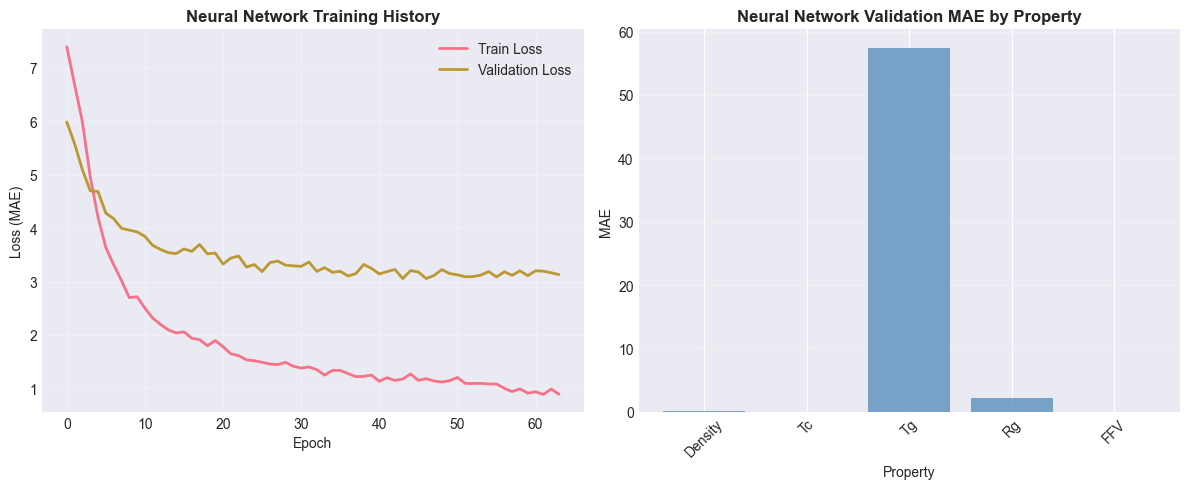


Neural Network Validation MAE:
Density: 0.0989
Tc: 0.0474
Tg: 57.4719
Rg: 2.1743
FFV: 0.0191


In [50]:
# Plot training history
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss', linewidth=2)
plt.plot(val_losses, label='Validation Loss', linewidth=2)
plt.xlabel('Epoch')
plt.ylabel('Loss (MAE)')
plt.title('Neural Network Training History', fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)

# Get predictions from neural network
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
nn_model.eval()
with torch.no_grad():
    X_test_tensor = torch.FloatTensor(X_test_scaled).to(device)
    nn_predictions = nn_model(X_test_tensor).cpu().numpy()

# Compare with baseline on validation set
with torch.no_grad():
    X_val_tensor = torch.FloatTensor(X_val).to(device)
    nn_val_pred = nn_model(X_val_tensor).cpu().numpy()

# Calculate MAE for each property
plt.subplot(1, 2, 2)
nn_val_maes = []
for i, prop in enumerate(TARGET_PROPERTIES):
    mask = ~np.isnan(y_val[:, i])
    if mask.sum() > 0:
        mae = mean_absolute_error(y_val[mask, i], nn_val_pred[mask, i])
        nn_val_maes.append(mae)
    else:
        nn_val_maes.append(0)

plt.bar(TARGET_PROPERTIES, nn_val_maes, alpha=0.7, color='steelblue')
plt.xlabel('Property')
plt.ylabel('MAE')
plt.title('Neural Network Validation MAE by Property', fontweight='bold')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print("\nNeural Network Validation MAE:")
for prop, mae in zip(TARGET_PROPERTIES, nn_val_maes):
    print(f"{prop}: {mae:.4f}")

## 8. Ensemble Predictions

Combine predictions from gradient boosting models and neural network:

In [51]:
# Create ensemble predictions
# Weight: 70% gradient boosting, 30% neural network
ensemble_weight_gb = 0.7
ensemble_weight_nn = 0.3

final_predictions = {}

for i, prop in enumerate(TARGET_PROPERTIES):
    # Gradient boosting predictions (already stored)
    gb_pred = test_predictions[prop]
    
    # Neural network predictions
    nn_pred = nn_predictions[:, i]
    
    # Ensemble
    final_pred = ensemble_weight_gb * gb_pred + ensemble_weight_nn * nn_pred
    final_predictions[prop] = final_pred
    
    print(f"{prop}:")
    print(f"  GB range: [{gb_pred.min():.4f}, {gb_pred.max():.4f}]")
    print(f"  NN range: [{nn_pred.min():.4f}, {nn_pred.max():.4f}]")
    print(f"  Ensemble range: [{final_pred.min():.4f}, {final_pred.max():.4f}]")
    print()

print("Ensemble predictions created!")

Density:
  GB range: [1.0584, 1.1797]
  NN range: [0.7463, 0.8748]
  Ensemble range: [0.9648, 1.0606]

Tc:
  GB range: [0.1937, 0.2678]
  NN range: [0.1943, 0.2788]
  Ensemble range: [0.1939, 0.2711]

Tg:
  GB range: [56.5718, 179.1769]
  NN range: [0.4338, 44.0342]
  Ensemble range: [52.8105, 136.2010]

Rg:
  GB range: [18.6301, 22.5225]
  NN range: [6.9460, 15.4357]
  Ensemble range: [16.2229, 17.8495]

FFV:
  GB range: [0.3494, 0.3752]
  NN range: [0.3634, 0.3673]
  Ensemble range: [0.3548, 0.3717]

Ensemble predictions created!


## 9. Create Submission File

In [52]:
# Prepare submission based on sample_submission format
submission = sample_submission.copy()

# The submission format might be wide (one row per polymer) or long (one row per prediction)
# Check the format
print("Sample submission format:")
print(sample_submission.head())
print(f"\nShape: {sample_submission.shape}")
print(f"Columns: {sample_submission.columns.tolist()}")

# Assuming wide format with columns for each property
# If the format is different, adjust accordingly

if 'id' in submission.columns:
    # Wide format: id, density, Tc, Tg, Rg, FFV
    for prop in TARGET_PROPERTIES:
        if prop in submission.columns:
            submission[prop] = final_predictions[prop]
else:
    # Long format: might need different handling
    # This would depend on the actual submission format
    pass

# Save submission
submission_path = DATA_DIR / 'submission.csv'
submission.to_csv(submission_path, index=False)

print(f"\nSubmission file saved to: {submission_path}")
print(f"Submission shape: {submission.shape}")
print("\nFirst few rows of submission:")
display(submission.head(10))

print("\nSubmission statistics:")
display(submission.describe())

Sample submission format:
           id  Tg  FFV  Tc  Density  Rg
0  1109053969   0    0   0        0   0
1  1422188626   0    0   0        0   0
2  2032016830   0    0   0        0   0

Shape: (3, 6)
Columns: ['id', 'Tg', 'FFV', 'Tc', 'Density', 'Rg']

Submission file saved to: C:\Users\gopeami\OneDrive - Vesuvius\Desktop\PhD13- 2025-2026\ML Practice\Kaggle Compettition\NeuIPS Polymer\neurips-open-polymer-prediction-2025\submission.csv
Submission shape: (3, 6)

First few rows of submission:


,id,Tg,FFV,Tc,Density,Rg
0,1109053969,136.201042,0.370477,0.193878,1.060624,17.849508
1,1422188626,119.874925,0.371657,0.230372,0.964753,16.222910
2,2032016830,52.810522,0.354794,0.271113,1.048954,17.671751



Submission statistics:


,id,Tg,FFV,Tc,Density,Rg
count,3.000000e+00,3.000000,3.000000,3.000000,3.000000,3.000000
mean,1.521086e+09,102.962163,0.365643,0.231788,1.024777,17.248056
std,4.693620e+08,44.193052,0.009413,0.038637,0.052309,0.892241
min,1.109054e+09,52.810522,0.354794,0.193878,0.964753,16.222910
25%,1.265621e+09,86.342724,0.362635,0.212125,1.006853,16.947330
50%,1.422189e+09,119.874925,0.370477,0.230372,1.048954,17.671751
75%,1.727103e+09,128.037984,0.371067,0.250742,1.054789,17.760630
max,2.032017e+09,136.201042,0.371657,0.271113,1.060624,17.849508


## 10. Feature Importance Analysis

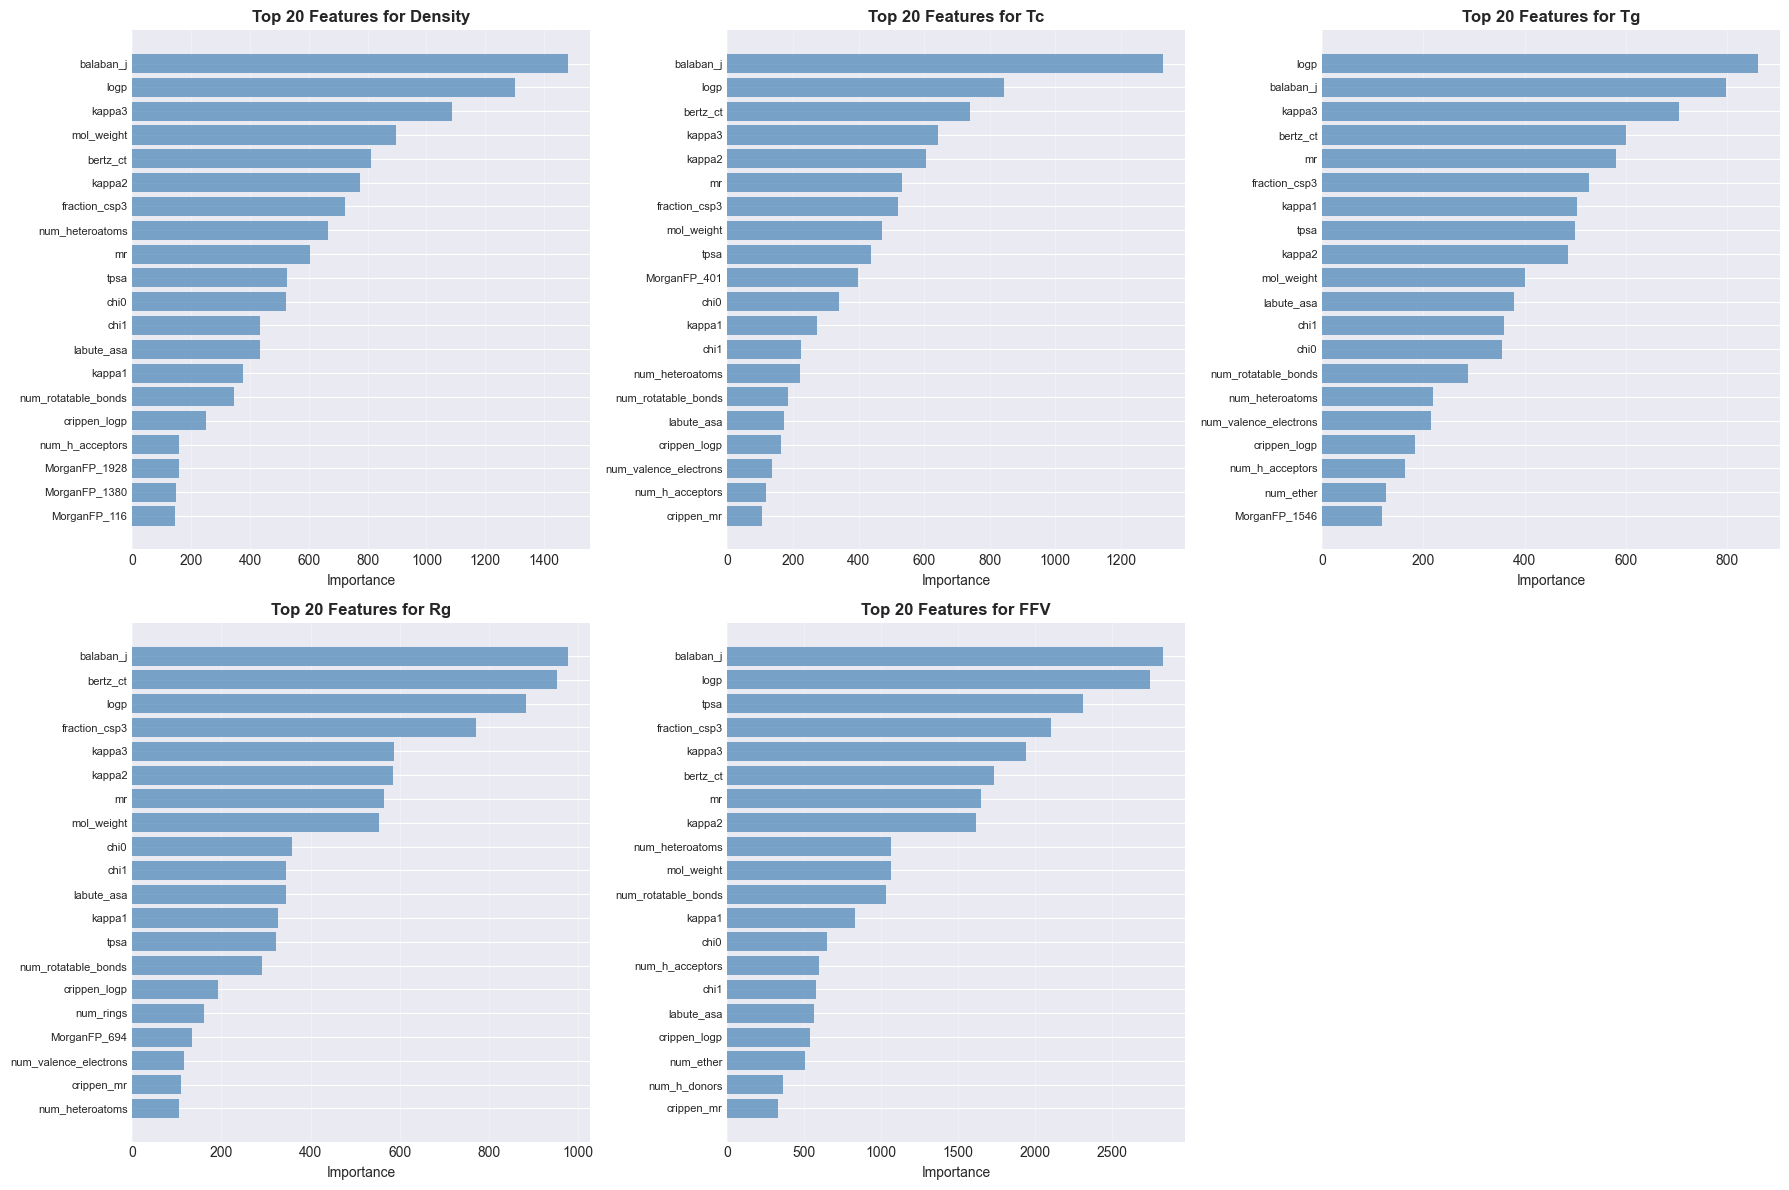


Top 10 Molecular Descriptors by Property:

Density:
  balaban_j: 1482.00
  logp: 1300.00
  kappa3: 1087.00
  mol_weight: 898.00
  bertz_ct: 811.00
  kappa2: 774.00
  fraction_csp3: 722.00
  num_heteroatoms: 665.00
  mr: 603.00
  tpsa: 525.00

Tc:
  balaban_j: 1329.00
  logp: 844.00
  bertz_ct: 740.00
  kappa3: 643.00
  kappa2: 607.00
  mr: 533.00
  fraction_csp3: 519.00
  mol_weight: 473.00
  tpsa: 439.00
  chi0: 340.00

Tg:
  logp: 862.00
  balaban_j: 799.00
  kappa3: 705.00
  bertz_ct: 601.00
  mr: 580.00
  fraction_csp3: 528.00
  kappa1: 504.00
  tpsa: 499.00
  kappa2: 485.00
  mol_weight: 401.00

Rg:
  balaban_j: 978.00
  bertz_ct: 953.00
  logp: 884.00
  fraction_csp3: 770.00
  kappa3: 587.00
  kappa2: 584.00
  mr: 565.00
  mol_weight: 554.00
  chi0: 358.00
  labute_asa: 345.00

FFV:
  balaban_j: 2832.00
  logp: 2745.00
  tpsa: 2312.00
  fraction_csp3: 2104.00
  kappa3: 1939.00
  bertz_ct: 1735.00
  mr: 1646.00
  kappa2: 1614.00
  num_heteroatoms: 1062.00
  mol_weight: 1061.00


In [53]:
# Analyze feature importance from LightGBM models
feature_names = list(train_desc.columns) + [f'MorganFP_{i}' for i in range(train_fps.shape[1])]

# Get top features for each property
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

for idx, prop in enumerate(TARGET_PROPERTIES):
    lgb_model = models[prop]['lgb']
    
    # Get feature importance
    importance = lgb_model.feature_importances_
    
    # Get top 20 features
    top_indices = np.argsort(importance)[-20:][::-1]
    top_importance = importance[top_indices]
    top_names = [feature_names[i] if i < len(feature_names) else f'Feature_{i}' for i in top_indices]
    
    # Plot
    axes[idx].barh(range(len(top_importance)), top_importance, color='steelblue', alpha=0.7)
    axes[idx].set_yticks(range(len(top_importance)))
    axes[idx].set_yticklabels(top_names, fontsize=8)
    axes[idx].set_xlabel('Importance')
    axes[idx].set_title(f'Top 20 Features for {prop}', fontweight='bold')
    axes[idx].invert_yaxis()
    axes[idx].grid(True, alpha=0.3, axis='x')

axes[-1].axis('off')
plt.tight_layout()
plt.show()

# Print top 10 most important molecular descriptors (excluding fingerprints)
print("\nTop 10 Molecular Descriptors by Property:")
print("="*60)
for prop in TARGET_PROPERTIES:
    lgb_model = models[prop]['lgb']
    importance = lgb_model.feature_importances_[:len(train_desc.columns)]  # Only descriptors
    
    top_10_idx = np.argsort(importance)[-10:][::-1]
    top_10_features = [train_desc.columns[i] for i in top_10_idx]
    top_10_values = importance[top_10_idx]
    
    print(f"\n{prop}:")
    for feat, val in zip(top_10_features, top_10_values):
        print(f"  {feat}: {val:.2f}")